In [1]:
import pandas as pd
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import subprocess
from tqdm.notebook import tqdm

# Different workloads

In [2]:
def get_mean_std_workloads(n_blocks, n_threads_per_block, n_floats, n_runs=100, n_warmup=10, workload=0):
    cmd_res = subprocess.run(["./a.out", *[str(x) for x in [n_blocks, n_threads_per_block, n_runs, n_warmup, n_floats, workload]]], capture_output=True, text=True)
    cmd_res.check_returncode()
    measurements = [np.fromstring(x, sep=" ") for x in cmd_res.stdout.split("\n")[:2]]
    
    res = []
    for m in measurements:
        res.append(np.mean(m))
        res.append(np.std(m))

    return res

In [3]:
# parameters
n_runs = 10
n_warmup = 10
n_blocks = 100
n_threads_per_block = 1024
n_floats = 20

# workloads
workloads = {
    "sum_reduce": 0,
    "prod_reduce": 1,
    "max_reduce": 2,
    "pair_prod" : 3,
    "sum_all_prod": 4,
    "time_malloc" : 10
}

## Sum vs Product

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

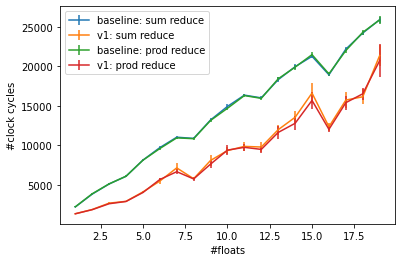

In [4]:
floats = list(range(1, n_floats))
results = []
for n_floats in tqdm(floats):
    results.append(get_mean_std_workloads(n_blocks=n_blocks, n_threads_per_block=n_threads_per_block,\
                                          n_floats=n_floats, n_runs=n_runs, n_warmup=n_warmup, workload=workloads["sum_reduce"]))

means_base_sum_reduce, stds_base_sum_reduce,\
means_v1_sum_reduce, stds_v1_sum_reduce\
= zip(*results)

results = []
for n_floats in tqdm(floats):
    results.append(get_mean_std_workloads(n_blocks=n_blocks, n_threads_per_block=n_threads_per_block,\
                                          n_floats=n_floats, n_runs=n_runs, n_warmup=n_warmup, workload=workloads["prod_reduce"]))

means_base_prod_reduce, stds_base_prod_reduce,\
means_v1_prod_reduce, stds_v1_prod_reduce\
= zip(*results)

plt.errorbar(floats, means_base_sum_reduce, stds_base_sum_reduce, label="baseline: sum reduce")
plt.errorbar(floats, means_v1_sum_reduce, stds_v1_sum_reduce, label="v1: sum reduce")
plt.errorbar(floats, means_base_prod_reduce, stds_base_prod_reduce, label="baseline: prod reduce")
plt.errorbar(floats, means_v1_prod_reduce, stds_v1_prod_reduce, label="v1: prod reduce")
plt.legend()

#plt.yscale("log")
plt.xlabel("#floats")
plt.ylabel("#clock cycles")
plt.show()

## Pairwise product vs Sum of all products

In [ ]:
floats = list(range(1, n_floats))
results = []
for n_floats in tqdm(floats):
    results.append(get_mean_std_workloads(n_blocks=n_blocks, n_threads_per_block=n_threads_per_block,\
                                          n_floats=n_floats, n_runs=n_runs, n_warmup=n_warmup, workload=workloads["pair_prod"]))

means_base_pair_prod, stds_base_pair_prod,\
means_v1_pair_prod, stds_v1_pair_prod\
= zip(*results)

results = []
for n_floats in tqdm(floats):
    results.append(get_mean_std_workloads(n_blocks=n_blocks, n_threads_per_block=n_threads_per_block,\
                                          n_floats=n_floats, n_runs=n_runs, n_warmup=n_warmup, workload=workloads["sum_all_prod"]))

means_base_sum_all_prod, stds_base_sum_all_prod,\
means_v1_sum_all_prod, stds_v1_sum_all_prod\
= zip(*results)

plt.errorbar(floats, means_base_pair_prod, stds_base_pair_prod, label="baseline: pair_prod")
plt.errorbar(floats, means_v1_pair_prod, stds_v1_pair_prod, label="v1: pair_prod")
plt.errorbar(floats, means_base_sum_all_prod, stds_base_sum_all_prod, label="baseline: sum_all_prod")
plt.errorbar(floats, means_v1_sum_all_prod, stds_v1_sum_all_prod, label="v1: sum_all_prod")
plt.legend()

#plt.yscale("log")
plt.xlabel("#floats")
plt.ylabel("#clock cycles")
plt.show()

## Malloc timing

In [ ]:
floats = list(range(1, n_floats))
results = []
for n_floats in tqdm(floats):
    results.append(get_mean_std_workloads(n_blocks=n_blocks, n_threads_per_block=n_threads_per_block,\
                                          n_floats=n_floats, n_runs=n_runs, n_warmup=n_warmup, workload=workloads["time_malloc"]))

means_base_malloc_time, stds_base_malloc_time,\
means_v1_malloc_time, stds_v1_malloc_time\
= zip(*results)

#results = []
#for n_floats in tqdm(floats):
#    results.append(get_mean_std_workloads(n_blocks=n_blocks, n_threads_per_block=n_threads_per_block,\
#                                          n_floats=n_floats, n_runs=n_runs, n_warmup=n_warmup, workload=workloads["sum_all_prod"]))

#means_base_sum_all_prod, stds_base_sum_all_prod,\
#means_v1_sum_all_prod, stds_v1_sum_all_prod\
#= zip(*results)

plt.errorbar(floats, means_base_malloc_time, stds_base_malloc_time, label="baseline: Malloc time")
plt.errorbar(floats, means_v1_malloc_time, stds_v1_malloc_time, label="v1: Malloc time")
#plt.errorbar(floats, means_base_sum_all_prod, stds_base_sum_all_prod, label="baseline: sum_all_prod")
#plt.errorbar(floats, means_v1_sum_all_prod, stds_v1_sum_all_prod, label="v1: sum_all_prod")
plt.legend()

#plt.yscale("log")
plt.xlabel("#floats")
plt.ylabel("#clock cycles")
plt.show()

## sum reduce with variable N_Blocks, N_threads_per_block

In [ ]:
floats = list(range(1, n_floats))

plt.rcParams['figure.figsize'] = [15, 10]
fig, axs = plt.subplots(3, 3)

for i, n_blocks in enumerate([100, 50, 1]):
    for j, n_threads_per_block in enumerate([1024, 128, 32]):
        
        results = []
        for n_floats in tqdm(floats):
            results.append(get_mean_std_workloads(n_blocks=n_blocks, n_threads_per_block=n_threads_per_block,\
                                                  n_floats=n_floats, n_runs=n_runs, n_warmup=n_warmup, workload=workloads["sum_reduce"]))

        means_base_sum_reduce, stds_base_sum_reduce,\
        means_v1_sum_reduce, stds_v1_sum_reduce\
        = zip(*results)

        axs[i, j].errorbar(floats, means_base_sum_reduce, stds_base_sum_reduce, label="baseline: sum reduce")
        axs[i, j].errorbar(floats, means_v1_sum_reduce, stds_v1_sum_reduce, label="v1: sum reduce")
        axs[i, j].legend()

        #plt.yscale("log")
        axs[i, j].set_xlabel("#floats")
        axs[i, j].set_ylabel("#clock cycles")
        
        
plt.show()

  0%|          | 0/12 [00:00<?, ?it/s]

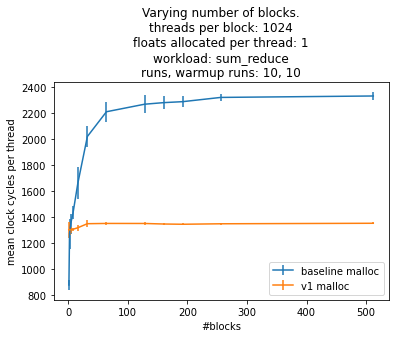

In [6]:
blocks = list([1, 2, 4, 8, 16, 32, 64, 128, 160, 192, 256, 512])

# parameters
n_runs = 10
n_warmup = 10
n_threads_per_block = 1024
n_floats = 1
   
results = []
for n_blocks in tqdm(blocks):
    results.append(get_mean_std_workloads(n_blocks=n_blocks, n_threads_per_block=n_threads_per_block,\
                                          n_floats=n_floats, n_runs=n_runs, n_warmup=n_warmup, workload=workloads["sum_reduce"]))

means_base_sum_reduce, stds_base_sum_reduce,\
means_v1_sum_reduce, stds_v1_sum_reduce\
= zip(*results)

plt.errorbar(blocks, means_base_sum_reduce, stds_base_sum_reduce, label="baseline malloc")
plt.errorbar(blocks, means_v1_sum_reduce, stds_v1_sum_reduce, label="v1 malloc")
plt.legend()

plt.title("Varying number of blocks." \
          + "\nthreads per block: " + str(n_threads_per_block)\
          + "\nfloats allocated per thread: " + str(n_floats)\
          + "\nworkload: sum_reduce"\
          + "\nruns, warmup runs: " + str(n_runs) + ", " + str(n_warmup))
#plt.yscale("log")
#plt.xscale("log")
plt.xlabel("#blocks")
plt.ylabel("mean clock cycles per thread")
        
        
plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]

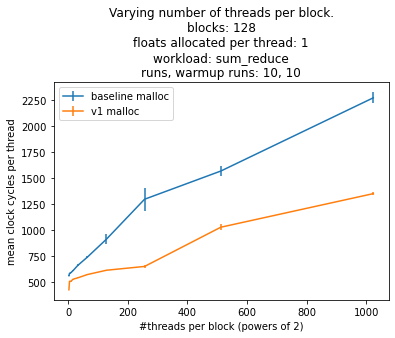

In [8]:
threads = list([2, 4, 8, 16, 32, 64, 128, 256, 512, 1024])

# parameters
n_runs = 10
n_warmup = 10
n_blocks = 128
#n_threads_per_block = 1024
n_floats = 1
   
results = []
for n_threads_per_block in tqdm(threads):
    results.append(get_mean_std_workloads(n_blocks=n_blocks, n_threads_per_block=n_threads_per_block,\
                                          n_floats=n_floats, n_runs=n_runs, n_warmup=n_warmup, workload=workloads["sum_reduce"]))

means_base_sum_reduce, stds_base_sum_reduce,\
means_v1_sum_reduce, stds_v1_sum_reduce\
= zip(*results)

plt.errorbar(threads, means_base_sum_reduce, stds_base_sum_reduce, label="baseline malloc")
plt.errorbar(threads, means_v1_sum_reduce, stds_v1_sum_reduce, label="v1 malloc")
plt.legend()

plt.title("Varying number of threads per block." \
          + "\nblocks: " + str(n_blocks)\
          + "\nfloats allocated per thread: " + str(n_floats)\
          + "\nworkload: sum_reduce"\
          + "\nruns, warmup runs: " + str(n_runs) + ", " + str(n_warmup))
#plt.yscale("log")
#plt.xscale("log")
plt.xlabel("#threads per block (powers of 2)")
plt.ylabel("mean clock cycles per thread")
        
        
plt.show()